##Final Evaluation of the fine-tuned open source models with the test data labelled by a human

After successfully doing a hyperparameter optimization and fine-tuning the open-source model ""distilbert-base-multilingual-cased-sentiments-student" by "lxyuan, the here presented notebooks is making a final evaluation of the fine-tuned model on the test data labelled by a human.

The following fine-tuned model was used:
 - set_15_lr1e-06_gracc1_bs32_te50_note/checkpoint-6250

The metrics for evaluation included calculation of accuracy, macro average for precision, recall and F1 score as well as the precision, recall and F1 score for each individual class and generating confusion matrices.

In [ ]:
! pip install -q transformers[torch] datasets

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
import yaml
with open ("/content/drive/MyDrive/github_projects/fine_tuning_ai_for_sentiments/config/config.yaml", "r") as f:
  config = yaml.safe_load(f)

### loading of the data and preparing the dataset object

In [ ]:
# load the test data with 100 manually assigned labels and
# drop unnecessary columns and rename the label column
df_test_data = (
    pd.read_csv(config["project_path"]+config["data_raw_dir"]+"forum_posts_100_test_classification_by_human.csv")
    .drop(columns = ["text", "datetime", "company"])                # dropping the unnecessary columns
    .rename(columns={"classification_by_human": "label"})           # renaming the column containing the labels
    .replace({"label" : {"positive":0, "neutral":1, "negative":2}}) # replacing "positive" with 0, "neutral" with 1 and "negative" with 2
    .astype({"label": "int32"})                                     # Making sure the labels will be formated as integers in future pandas versions
    .merge(                                                         # adding the posts/texts to the dataframe using the ID as key to call the texts from the file with all information
        pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_all_initial.csv")
        [["ID", "text"]],
        how="left",
        on="ID"
    )
    .drop(columns="ID")                                             # dropping the ID column as preparation to feed the data to the models
    .set_index("label")                                             # setting the lable as index as required by the models
)
display(df_test_data)

<ipython-input-4-f6bf343a16fa>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"label" : {"positive":0, "neutral":1, "negative":2}}) # replacing "positive" with 0, "neutral" with 1 and "negative" with 2


,text
label,
2,"Lass das nicht Deine Perle lesen, sonst musst..."
0,"Wirecard ist zu unrecht abgestraft, ich finde..."
2,"jo und den chart anschauen, nie am höchepunkt..."
1,godmode-trader.de
1,"Das gilt nur für die Adler Group SA, oder auch..."
...,...
0,Bin ja auch sehr optimistisch gestimmt. ...
2,heute sieht es so aus als würde die Unters...
1,"Wieder keine Vola, obwohl der Gesamtmarkt neu..."


In [ ]:
# converting the dataframe into a Dataset object
test_dataset = Dataset.from_pandas(df_test_data)
print(test_dataset, "\n")

# performing a sanity check to verify that the labels are integers
print(test_dataset[0]["label"].__class__, "\n")

# accessing an example forum post with its label to verify the structure of the data
test_dataset[1]


Dataset({
    features: ['text', 'label'],
    num_rows: 100
}) 

<class 'int'> 



{'text': ' Wirecard ist zu unrecht abgestraft, ich finde sie Stand heute unterbewertet.  Q1 und der weitere Ausblick werden eine deutliche Sprache sprechen. Die Frage ist in weit sich der Europäische Markt vom US Markt abkoppeln kann, den ich in einigen Sektoren derzeit nicht als überbewertet empfinde. Es konnte durchaus sein das der Dollar in Europa geparkt wird. Wir werden sehen....',
 'label': 0}

### tokenizing the test data in the dataset object

In [ ]:
# loading the tokenizer from the model fine-tuned model distilbert-base-multilingual-cased-sentiments-student
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# creating a function for tokenization
def tokenize_function(batch):
    # tokenize the text in in the batch
    tokens = tokenizer(batch["text"], padding="max_length", truncation=True)
    return tokens

# tokenizing the texts from the posts in the dataset object
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### establishing the metrics

In [ ]:
def compute_metrics(p):
    """
    computes various metrics including accuracy, macro average for precision, recall and F1 score
    as well as the precision, recall and F1 score for each individual class.

    parameters:
    - p (object) : an object which contains "predictions" and "label_ids",
                   and is provided by the Hugging Face's Trainer during the evaluation phase.

    returns:
    - dict: a dictionary containing the accuracy, the macro average for precision, recall and F1 score
            and precision, recall and F1 score for each individual class.
    """

    # getting the predicted label by taking the argmax of the predictions
    predictions = np.argmax(p.predictions, axis=1)

    # extracting the labels
    labels = p.label_ids

    # computing the accuracy
    accuracy = accuracy_score(labels, predictions)

    # computing macro average precision, recall and F1 score with each class having the same weight
    macro_average_precision = precision_score(labels, predictions, average="macro")     #alternative: average="weighted"
    macro_average_recall = recall_score(labels, predictions, average="macro")           #alternative: average="weighted"
    macro_average_f1 = f1_score(labels, predictions, average="macro")                   #alternative: average="weighted"

    # computing per-class precision, recall and F1 score
    precision = precision_score(labels, predictions, average=None, zero_division=0)
    recall = recall_score(labels, predictions, average=None, zero_division=0)
    f1 = f1_score(labels, predictions, average=None, zero_division=0)

    # initiating a dictionary to store the accuracy and macro average metrics
    metrics = {
        "accuracy": accuracy,
        "macro_av_precision": macro_average_precision,
        "macro_av_recall": macro_average_recall,
        "macro_av_f1": macro_average_f1
    }

    # adding per-class precision, recall, and f1 metrics to the dictionary
    for i, (prec, rec, f1_val) in enumerate(zip(precision, recall, f1)):
        metrics[f"precision_class_{i}"] = prec
        metrics[f"recall_class_{i}"] = rec
        metrics[f"f1_class_{i}"] = f1_val

    # optional print statement
    # print(metrics)

    return metrics

### loading the different models and calculating their metrics

In [ ]:
!pip install triton

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"         # needed to avoid errors possibly replace by using

In [ ]:
model_list = [
    {"model_name" : "initial model", "model_path" : "lxyuan/distilbert-base-multilingual-cased-sentiments-student", "num_labels" : 3},
    #{"model_name" : "set_02_lr1e-05_gracc1_bs8_te10_note/checkpoint-5000"},
    #{"model_name" : "set_05_lr1e-05_gracc2_bs8_te10_note/checkpoint-2500"},
    #{"model_name" : "set_12_lr1e-05_gracc1_bs32_te10_note/checkpoint-1250"},
    {"model_name" : "set_15_lr1e-06_gracc1_bs32_te50_note/checkpoint-6250"},
    #{"model_name" : "set_15_lr1e-06_gracc1_bs32_te50_note/checkpoint-2000"},
    #{"model_name" : "set_16_lr5e-06_gracc1_bs32_te50_note/checkpoint-6250"}
   ]

# initializing and empty dataframe to collect evaluation metrics
df_collected_eval = pd.DataFrame()

# initializing a dataframe and loading the texts of the posts human assigned
# this will serve as a base to collect the predictions from the different models
df_collected_predictions =  (
  pd.DataFrame({
      "text": df_test_data["text"],
      "classification_by_human": df_test_data.index
      })
  .reset_index(drop=True)
)

# iterating through the different models (initial and selected fine-tuned ones)
for model_instance in model_list:
  model_name = model_instance["model_name"]

  # conditional loading
  if "num_labels" in model_instance:
      model = AutoModelForSequenceClassification.from_pretrained(model_instance["model_path"], num_labels = model_instance["num_labels"])
  else:
      model = AutoModelForSequenceClassification.from_pretrained(config["project_path"]+config["models_dir"]+model_instance["model_name"])

  # initializing the trainer
  trainer = Trainer(
    model=model,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
  )

  # evaluate the model and get the metrics
  eval_result = trainer.evaluate()

  # collecting the metrics as data frame
  df_collected_eval = (
    pd.concat([
      df_collected_eval,
      pd.DataFrame([eval_result])
      .drop(columns=["eval_model_preparation_time", "eval_runtime", "eval_samples_per_second", "eval_steps_per_second"])
      .assign(model_name = model_name)
      .set_index("model_name")
    ])
  )

  # predicting the sentiment class for the 100 posts to allow more detailed analysis
  pred_output = trainer.predict(tokenized_test_dataset)

  # displaying the output of the preditions
  #display(pred_output)

  # accessing the predictions, lables and metrics
  predictions = pred_output.predictions
  label_ids = pred_output.label_ids
  metrics = pred_output.metrics

  # reading out the predicted class
  # explanation: it counts from left to right with the most left column being 0 (positive), middle 1 (neutral) and right 2 (negative)
  predicted_classes = np.argmax(predictions, axis=1)

  # adding the predicted classes to the df_collected_predictions
  df_collected_predictions["hp_"+model_instance["model_name"]] = predicted_classes

# beautification of the df_collected_predictions for improved readability
df_collected_eval.columns = (
    df_collected_eval.columns
      .str.replace("^eval_", "", regex=True)
      .str.replace("_", " ")
      .str.title()
)
# setting the index which currently contains the model names are regular column
df_collected_eval = df_collected_eval.reset_index()

print("Evaluation metrics and predictions collected:")
display(df_collected_eval)
display(df_collected_predictions)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Evaluation metrics and predictions collected:


,model_name,Loss,Accuracy,Macro Av Precision,Macro Av Recall,Macro Av F1,Precision Class 0,Recall Class 0,F1 Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Precision Class 2,Recall Class 2,F1 Class 2
0,initial model,1.220544,0.39,0.566306,0.422440,0.307300,0.280000,0.333333,0.304348,1.000000,0.022222,0.043478,0.418919,0.911765,0.574074
1,set_15_lr1e-06_gracc1_bs32_te50_note/checkpoin...,1.232378,0.54,0.562535,0.545689,0.520369,0.529412,0.428571,0.473684,0.666667,0.355556,0.463768,0.491525,0.852941,0.623656


,text,classification_by_human,hp_initial model,hp_set_15_lr1e-06_gracc1_bs32_te50_note/checkpoint-6250
0,"Lass das nicht Deine Perle lesen, sonst musst...",2,2,2
1,"Wirecard ist zu unrecht abgestraft, ich finde...",0,2,2
2,"jo und den chart anschauen, nie am höchepunkt...",2,0,1
3,godmode-trader.de,1,0,0
4,"Das gilt nur für die Adler Group SA, oder auch...",1,2,1
...,...,...,...,...
95,Bin ja auch sehr optimistisch gestimmt. ...,0,2,0
96,heute sieht es so aus als würde die Unters...,2,2,2
97,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",1,2,2
98,du wirst es nie lernen ! substanz sieht an...,2,2,2


#### saving the evaluations

In [ ]:
# # saving the collected evaluations and collected predictions to a CSV file each
# # warning: if you still run the following cells, you might overwrite the provided files with the defined sample
# df_collected_eval.to_csv(config["project_path"]+config["data_results_dir"]+"fine_tuned_model_evaluations_with_test.csv", index=False)
# df_collected_predictions.to_csv(config["project_path"]+config["data_results_dir"]+"fine_tuned_model_predictions_on_test.csv", index=False)

#### loading the evaluations from the saved CSV file

In [ ]:
# # in case you want to load the collected evaluations and collected predictions provided, you can run the following cell
# df_collected_eval = pd.read_csv(config["project_path"]+config["data_results_dir"]+"fine_tuned_model_evaluations_with_test.csv")
# df_collected_predictions = pd.read_csv(config["project_path"]+config["data_results_dir"]+"fine_tuned_model_predictions_on_test.csv")
# display(df_collected_eval)
# display(df_collected_predictions)

### creating confusion matrices

Confusion matrix for hp_initial model:


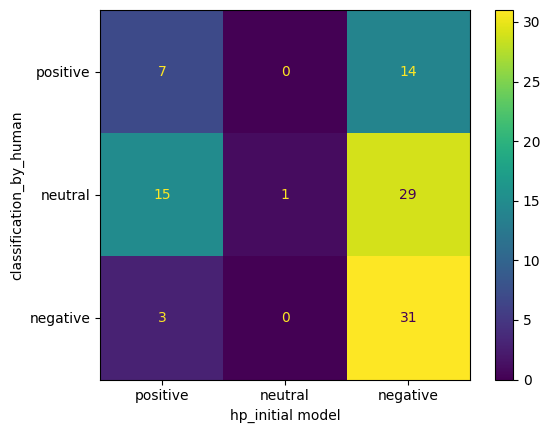

Confusion matrix for hp_set_15_lr1e-06_gracc1_bs32_te50_note/checkpoint-6250:


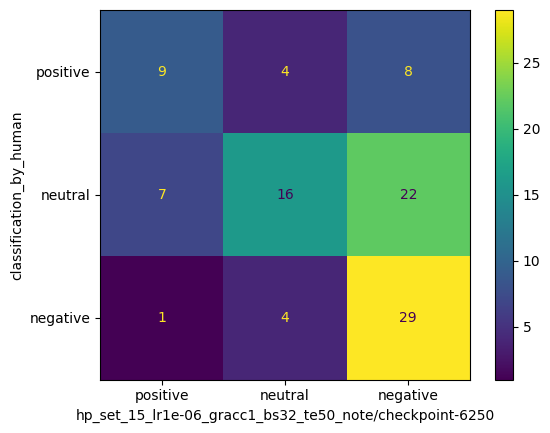

In [ ]:
# creating confusion matrices for the predictions using the selected models
for pred_column in df_collected_predictions.columns:
  if pred_column != "text" and pred_column != "classification_by_human":
    y_pred = df_collected_predictions[pred_column]
    y_true = df_collected_predictions["classification_by_human"]
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels= {'positive':0, 'neutral':1, 'negative':2})
    plt.xlabel(pred_column)
    plt.ylabel("classification_by_human")
    print(f"Confusion matrix for {pred_column}:")
    # optionally save each plot with the model name as the filename
    # clean_pred_column = pred_column.replace("/", "_")                 #replacing the "/" to avoid problems when saving
    # plt.savefig(config["project_path"]+config["data_results_dir"]+f"confusion_matrix_{clean_pred_column}.jpg", bbox_inches="tight")
    plt.show()

## Optional code for additional analysis

### confusion matrices for predictions using the two gpt models

In [ ]:
# # generating confusion matrices for predictions on the test set made by the two evaluated gpt models

# # loading the predictions made previously
# df_forum_posts_100_test_gpt_classified = pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test_classification_by_human_and_3_open_source_models_and_2_GPT_models.csv")

# # defining the true labels and select the model predictions
# y_true = df_forum_posts_100_test_gpt_classified["classification_by_human"]
# column_names_model_predictions = [
#     "sentiment_"+config["test_data_eval_model1"],
#     "sentiment_"+config["test_data_eval_model2"]
#     ]

# # generating and displaying a confusion matrix for each selected model
# for column_model_prediction in column_names_model_predictions:
#   y_pred = df_forum_posts_100_test_gpt_classified[column_model_prediction]

#   ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

#   # creating lables for clarity
#   plt.xlabel(column_model_prediction, fontsize=8)
#   plt.ylabel("classification_by_human", fontsize=8)
#   plt.title(f"The confusion matrix for using {column_model_prediction} for the forum_posts_100_test:", fontsize=8)

#   # showing the plot
#   plt.show()
#   print("\n"*2)

### creating larger number of confusion matrices with three per line and adjusted layout

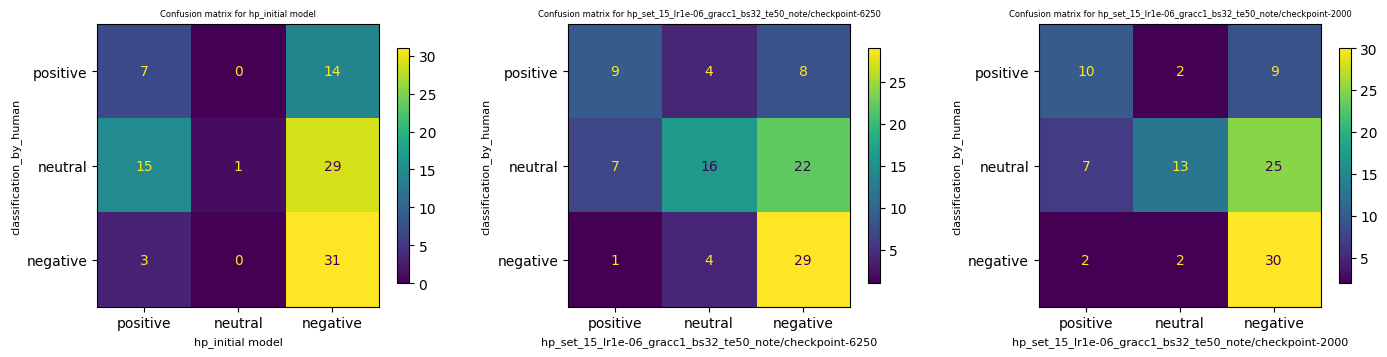

In [ ]:
# # The following cells allows to plot a large number of confusion matrices
# # with three confusion matrices and adjusted layout and sizes to look nice

# # Storing the true labels outside the loop
# y_true = df_collected_predictions["classification_by_human"]

# # Get the list of prediction columns excluding 'text' and 'classification_by_human'
# prediction_columns = [col for col in df_collected_predictions.columns if col not in ["text", "classification_by_human"]]

# # Define the number of columns per row (3 in this case)
# n_cols = 3
# n_rows = (len(prediction_columns) + n_cols - 1) // n_cols  # Calculate required number of rows

# # Create subplots (adjust the figure size as needed)
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

# # Flatten axes to make it easy to iterate
# axes = axes.flatten()

# # Loop through the prediction columns and plot each confusion matrix
# for i, pred_column in enumerate(prediction_columns):
#     y_pred = df_collected_predictions[pred_column]

#     # optionally display the confusion matrix on the specific subplot axis with a softer colormap (e.g., Blues)
#     disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['positive', 'neutral', 'negative'],
#                                             ax=axes[i])   #, cmap=plt.cm.Blues
#     # removing the original sized color bar one
#     disp.im_.colorbar.ax.remove()
#     # adding a colorbar with shrinked dimensions
#     plt.colorbar(disp.im_, ax=axes[i], shrink=0.5)  # Reducing the colorbar size by 50% compared to original size


#     # set axis labels and titles with smaller font size
#     axes[i].set_title(f"Confusion matrix for {pred_column}", fontsize=6)
#     axes[i].set_xlabel(pred_column, fontsize=8)
#     axes[i].set_ylabel("classification_by_human", fontsize=8)

#     # save each subplot with the model name as the filename
#     fig.savefig(f"confusion_matrix_{pred_column}.jpg", bbox_inches="tight")

# # Hide any unused axes if there are more subplots than confusion matrices
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# # Adjust layout to avoid overlapping
# plt.tight_layout()

# # Show the figure
# plt.show()